# Colab C1 — PyTorch Class-Based (Built-in Modules) — 3-hidden-layer DNN for Non-Linear Regression

**Key requirements satisfied:**
- Synthetic **3-variable** non-linear regression dataset (x1, x2, x3 → y)
- **Deep network with 3 hidden layers**
- Uses **PyTorch built-in modules** (`torch.nn.Module`, `nn.Linear`, built-in activations)
- Uses **built-in backprop** (`loss.backward()`) and **optimizer** (`torch.optim`)
- Shows **loss vs epochs** and **final predicted vs true** output plot
- Includes “4D” visualization: PCA (3D X → 2D) then plot (PC1, PC2, y) with color = x3


In [1]:
# =========================
# Cell 1 — Setup
# =========================
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

np.random.seed(7)
torch.manual_seed(7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [2]:
# =========================
# Cell 2 — Synthetic data (3 variables) + preprocessing
# =========================
N = 2000
X = np.random.uniform(-2.0, 2.0, size=(N, 3)).astype(np.float32)
x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]

noise = 0.10 * np.random.randn(N).astype(np.float32)
y = (
    np.sin(x1)
    + 0.5 * np.cos(x2 * x3)
    + 0.30 * (x2 ** 2)
    - 0.20 * (x3 ** 3)
    + 0.25 * np.sin(x1 * x2)
    + noise
).astype(np.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Standardize for stable training
X_mu, X_std = X_train.mean(axis=0, keepdims=True), X_train.std(axis=0, keepdims=True) + 1e-8
y_mu, y_std = y_train.mean(axis=0, keepdims=True), y_train.std(axis=0, keepdims=True) + 1e-8

X_train_n = (X_train - X_mu) / X_std
X_test_n  = (X_test  - X_mu) / X_std
y_train_n = (y_train - y_mu) / y_std
y_test_n  = (y_test  - y_mu) / y_std

print("Shapes:", X_train_n.shape, y_train_n.shape, X_test_n.shape, y_test_n.shape)


Shapes: (1600, 3) (1600, 1) (400, 3) (400, 1)


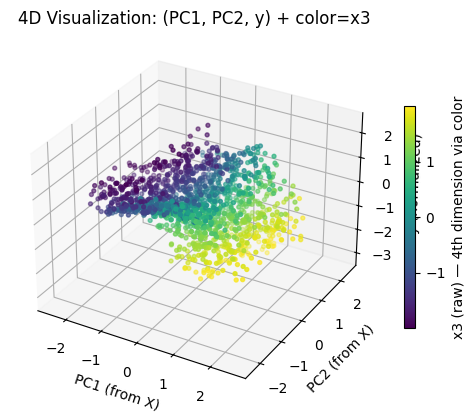

In [3]:
# =========================
# Cell 3 — 4D visualization (PCA for X, color = x3)
# =========================
pca = PCA(n_components=2, random_state=7)
X2 = pca.fit_transform(X_train_n)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(X2[:, 0], X2[:, 1], y_train_n[:, 0], c=X_train[:, 2], s=8)

ax.set_xlabel("PC1 (from X)")
ax.set_ylabel("PC2 (from X)")
ax.set_zlabel("y (normalized)")
fig.colorbar(sc, ax=ax, shrink=0.6, label="x3 (raw) — 4th dimension via color")
plt.title("4D Visualization: (PC1, PC2, y) + color=x3")
plt.show()


In [4]:
# =========================
# Cell 4 — Model (3 hidden layers) using nn.Module + nn.Linear
# =========================
class DeepRegressor(nn.Module):
    def __init__(self, in_dim=3, h1=32, h2=32, h3=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.Tanh(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, h3),
            nn.Tanh(),
            nn.Linear(h3, 1)  # linear output for regression
        )

    def forward(self, x):
        return self.net(x)

model = DeepRegressor().to(device)
print(model)


DeepRegressor(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


Epoch   1 | Loss (MSE, normalized): 0.359672
Epoch  50 | Loss (MSE, normalized): 0.017260
Epoch 100 | Loss (MSE, normalized): 0.013613
Epoch 150 | Loss (MSE, normalized): 0.010711
Epoch 200 | Loss (MSE, normalized): 0.011161
Epoch 250 | Loss (MSE, normalized): 0.009865
Epoch 300 | Loss (MSE, normalized): 0.010039


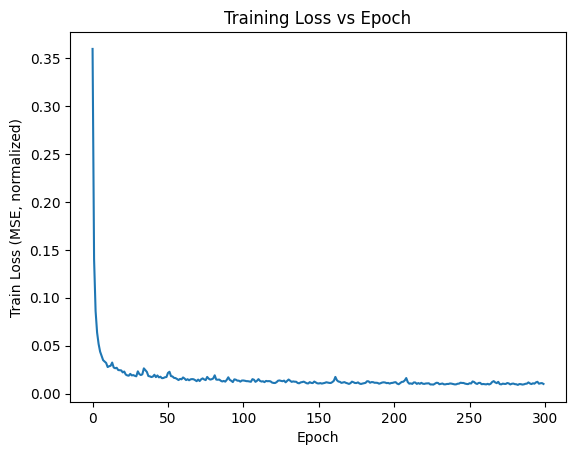

In [5]:
# =========================
# Cell 5 — Training (built-in backprop + optimizer)
# =========================
from torch.utils.data import TensorDataset, DataLoader

Xtr = torch.tensor(X_train_n, dtype=torch.float32)
ytr = torch.tensor(y_train_n, dtype=torch.float32)
Xte = torch.tensor(X_test_n,  dtype=torch.float32)
yte = torch.tensor(y_test_n,  dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=128, shuffle=True)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 300
losses = []

for ep in range(1, epochs + 1):
    model.train()
    ep_loss = 0.0
    steps = 0

    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        yhat = model(Xb)
        loss = criterion(yhat, yb)

        loss.backward()      # backprop
        optimizer.step()     # update weights

        ep_loss += loss.item()
        steps += 1

    ep_loss /= steps
    losses.append(ep_loss)

    if ep % 50 == 0 or ep == 1:
        print(f"Epoch {ep:3d} | Loss (MSE, normalized): {ep_loss:.6f}")

plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss (MSE, normalized)")
plt.title("Training Loss vs Epoch")
plt.show()


Test MSE (normalized): 0.014918
Test MSE (original scale): 0.016077


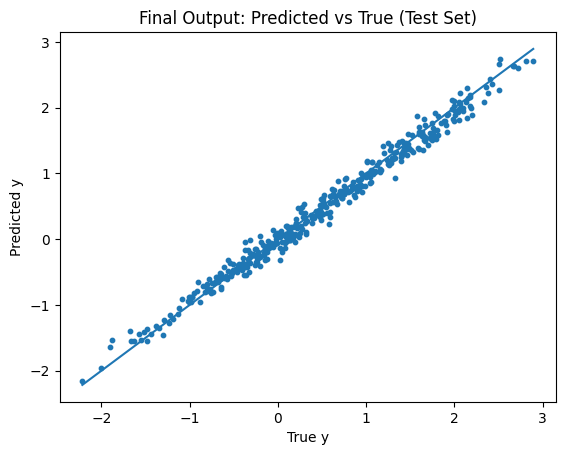

Sample 0: true= 0.0281 | pred=-0.1344
Sample 1: true= 1.2483 | pred= 1.4625
Sample 2: true=-0.7661 | pred=-0.7580
Sample 3: true= 1.8116 | pred= 1.5856
Sample 4: true= 1.6677 | pred= 1.7306


In [6]:
# =========================
# Cell 6 — Evaluation + final output
# =========================
model.eval()
with torch.no_grad():
    yhat_n = model(Xte.to(device)).cpu().numpy()
    test_mse_n = float(np.mean((yhat_n - y_test_n) ** 2))

# Unnormalize to original scale
yhat = (yhat_n * y_std + y_mu).reshape(-1, 1)
ytrue = y_test
test_mse = float(np.mean((yhat - ytrue) ** 2))

print(f"Test MSE (normalized): {test_mse_n:.6f}")
print(f"Test MSE (original scale): {test_mse:.6f}")

plt.figure()
plt.scatter(ytrue, yhat, s=10)
mn, mx = float(ytrue.min()), float(ytrue.max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Final Output: Predicted vs True (Test Set)")
plt.show()

for i in range(5):
    print(f"Sample {i}: true={ytrue[i,0]: .4f} | pred={yhat[i,0]: .4f}")
